In [362]:
import os
import os.path as osp
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import pandas as pd
import cv2
import matplotlib.patches as mpatches

> # EDA 

1. Number of annotations(objects) per category
2. Number of annotations(objects) per image
3. Segmentation Area distribution overall
4. Segmentation Area distribution per category

> # Config

In [302]:
data_dir = '../data'
train_json_path = osp.join(data_dir, 'train_new.json')
train_all_json_path = osp.join(data_dir, 'train_all_new.json')

###### Load train_all_new.json ######
with open(train_all_json_path, 'r') as f:
    train_all_json = json.load(f) 

###### Convert to COCO #######
coco_train = COCO(train_all_json_path)

categories = train_all_json['categories']
annotations = train_all_json['annotations']
images = train_all_json['images']

loading annotations into memory...
Done (t=2.93s)
creating index...
index created!


In [303]:
set([x['category_id'] for x in train_all_json['annotations']])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [304]:
train_all_json['categories']

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

> # Number of categories/images/annotations

In [305]:
n_categories = len(categories)
n_annotations = len(annotations)
n_images = len(images)

print("[Number of categories]: {}".format(n_categories))
print("[Number of annotations]: {}".format(n_annotations))
print("[Number of images]: {}".format(n_images))

[Number of categories]: 10
[Number of annotations]: 26931
[Number of images]: 3467


> # Number of annotations per category

In [306]:
cat_histogram = np.zeros(n_categories, dtype=np.int16)
cat_names = [c['name'] for c in categories]

for ann in annotations:
    cat_histogram[ann['category_id'] - 1] += 1
    
df = pd.DataFrame({'Category': cat_names, 'Number of Annotations': cat_histogram})
df = df.sort_values(by='Number of Annotations', axis=0, ascending=False)
df

,Category,Number of Annotations
1,Paper,9481
7,Plastic bag,7783
5,Plastic,3199
0,General trash,2906
6,Styrofoam,1376
2,Paper pack,683
4,Glass,625
3,Metal,616
9,Clothing,192
8,Battery,70


<AxesSubplot:xlabel='Number of Annotations', ylabel='Category'>

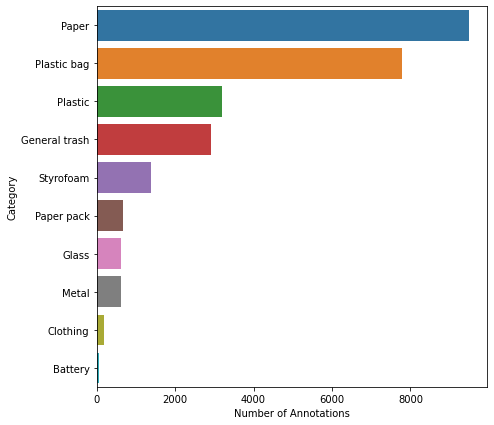

In [307]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(data=df, x='Number of Annotations', y='Category')

> # Number of Objects per image

<AxesSubplot:xlabel='number of objects per image', ylabel='Count'>

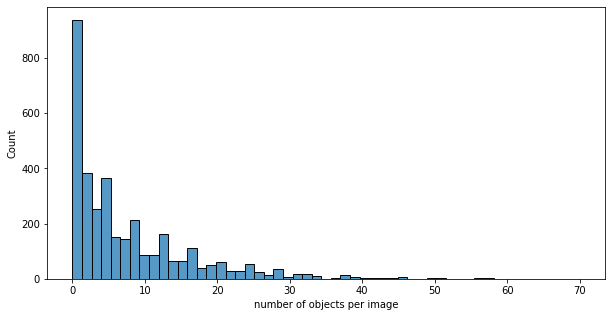

In [308]:
n_images = len(coco_train.getImgIds())
n_objects_per_img = [len(coco_train.getAnnIds(img_id)) for img_id in coco_train.getImgIds()]

df_2 = pd.DataFrame({'number of objects per image': n_objects_per_img})
plt.figure(figsize=(10,5))
sns.histplot(data=df_2, x='number of objects per image')

In [309]:
df_2.describe()

,number of objects per image
count,3467.000000
mean,7.767811
std,8.831991
min,0.000000
25%,1.000000
50%,4.000000
75%,11.000000
max,70.000000


> # Overall Segmentation Area 

(0.0, 10000.0)

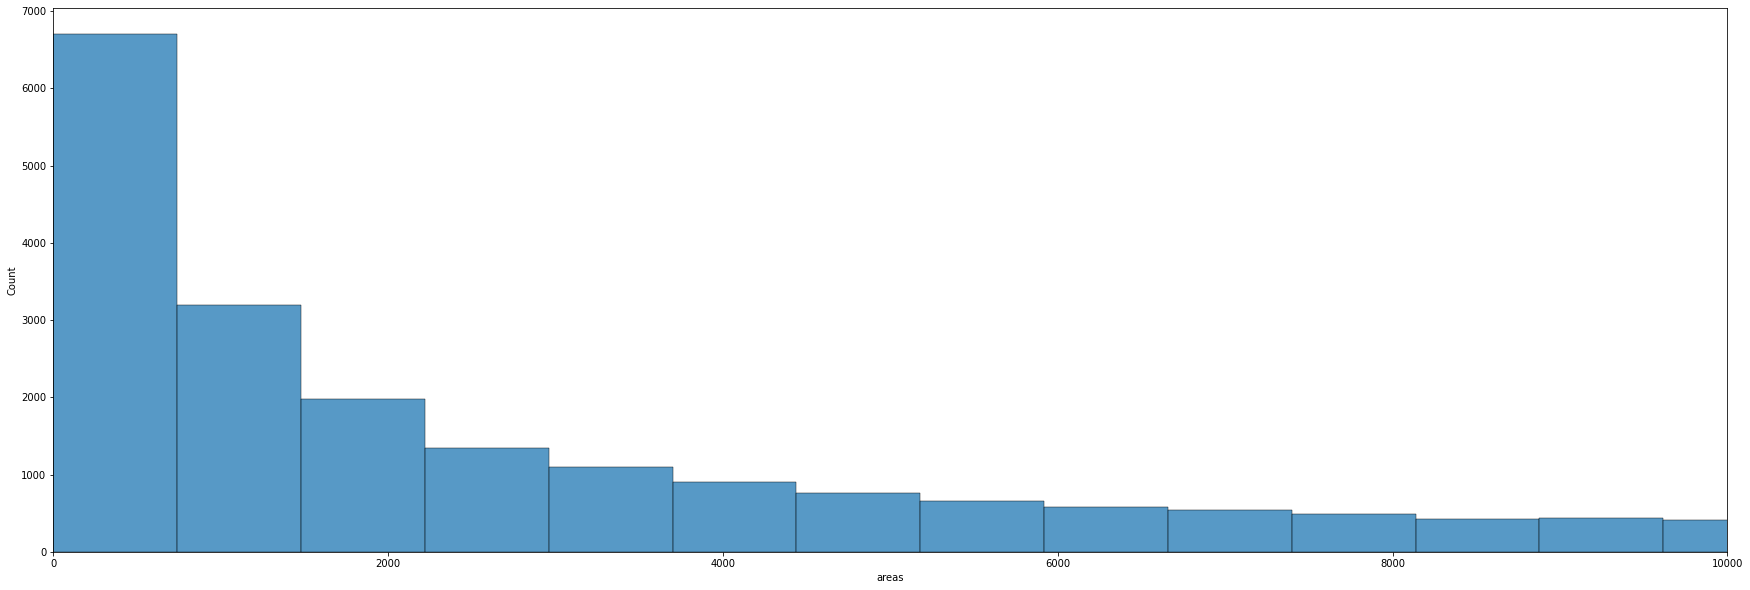

In [334]:
areas = [ann['area'] for ann in annotations]
df_3 = pd.DataFrame({'areas': areas})

fig, ax = plt.subplots(figsize=(30, 10))
sns.histplot(data=df_3, x='areas', ax=ax)
ax.set_xlim(0,10000)

In [325]:
df_3

,areas
0,6307.5
1,3313.5
2,4741.0
3,18560.5
4,9759.0
...,...
26926,4672.0
26927,6968.0
26928,32018.0
26929,19037.5


In [311]:
df_3.describe()

,areas
count,26931.000000
mean,10322.332572
std,18026.871568
min,1.000000
25%,748.000000
50%,3127.500000
75%,11851.500000
max,261109.000000


> # Segmentation Area per Category

In [144]:
categories

[{'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

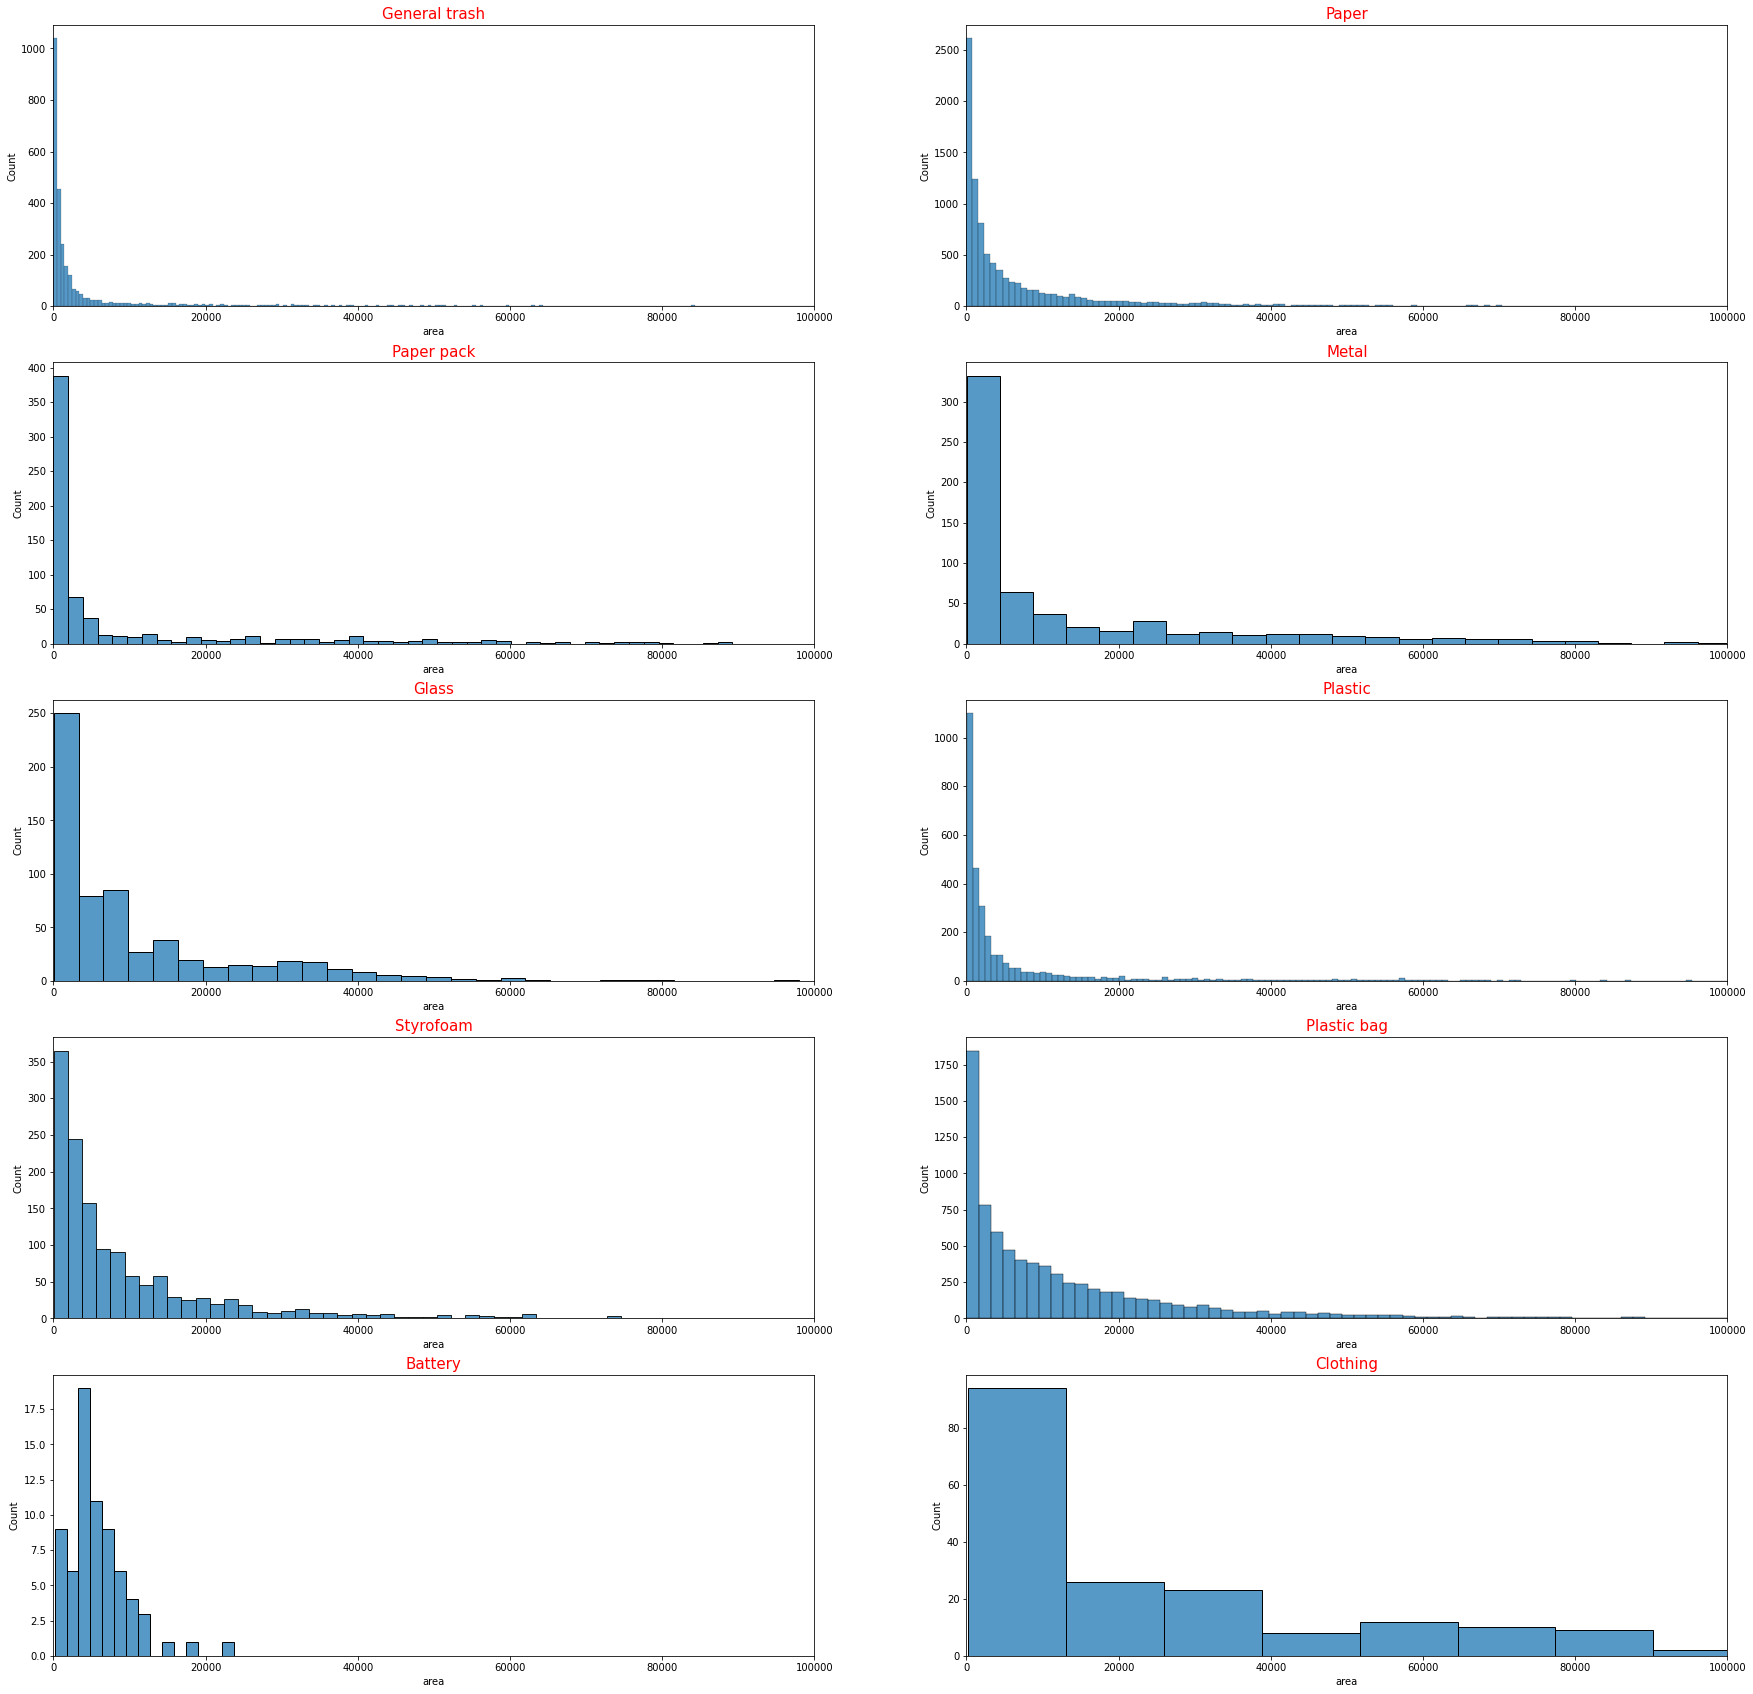

In [153]:
category_matching = df['Category'].sort_index().values
areas = [ann['area'] for ann in annotations]
cats = [ann['category_id'] for ann in annotations]

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(30, 30))

for i in range(5):
    for j in range(2):
        sns.histplot(data=df_4[df_4['category']==2*i+j+1], x='area', ax=ax[i][j])
        ax[i][j].set_xlim(0, 100000)
        ax[i][j].set_title(category_matching[2*i+j], color='r', fontsize=15)

> # Visualization

In [169]:
# category_names = list()
sorted_temp_df = df.sort_index()
sorted_df = pd.DataFrame(['Background'], columns=['Category'])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)
sorted_df

,Category,Number of Annotations
0,Background,NaN
1,General trash,2906.0
2,Paper,9481.0
3,Paper pack,683.0
4,Metal,616.0
5,Glass,625.0
6,Plastic,3199.0
7,Styrofoam,1376.0
8,Plastic bag,7783.0
9,Battery,70.0


In [172]:
category_names = list(sorted_df['Category'])

def get_classname(classId, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classId:
            return cats[i]['name']
        
    return 'None'

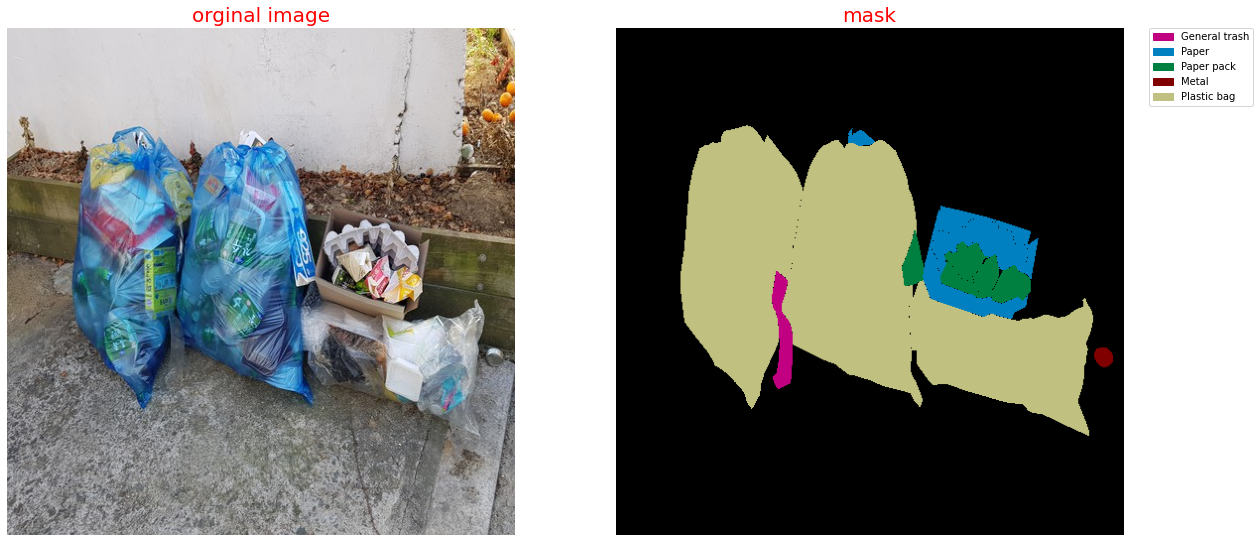

In [449]:
class_colormap = pd.read_csv('../code/class_dict.csv')

def label2clsname(label):
    return class_colormap.loc[label]['name']

def label2rgb(label):
    row = class_colormap.loc[label]
    rgb = (row['r']/255, row['g']/255, row['b']/255)
    return rgb

def show_mask(img_id):
    # Load Image
    img_info = coco_train.loadImgs(img_id)[0]
    img_path = '../data/' + img_info['file_name']
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img /= 255.0
    
    # Load Annotations
    ann_ids = coco_train.getAnnIds(img_id)
    ann_infos = coco_train.loadAnns(ann_ids)
    
    # Load Categories
    cat_ids = coco_train.getCatIds()
    cat_infos = coco_train.loadCats(cat_ids)
    
    # Mask
    masks = np.zeros((512, 512, 3))
    ann_infos = sorted(ann_infos, key=lambda ann: ann['area'], reverse=True)
    patches = []
    categories = set()
    
    # Starting from the largest, put masks
    for ann_info in ann_infos:
        cls_name = get_classname(ann_info['category_id'], cat_infos)
        pixel_value = category_names.index(cls_name)
        categories.add(pixel_value)
        masks[coco_train.annToMask(ann_info) == 1] = label2rgb(pixel_value)
        
    masks = masks.astype(np.float32)
    
    patches = [mpatches.Patch(color=label2rgb(x), label=label2clsname(x)) for x in categories]
    
    # Draw original image & mask
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 12))
    ax1.imshow(img)
    ax1.grid(False)
    ax1.set_title("orginal image", size=20, color='red')
    ax1.axis('off')
    
    im = ax2.imshow(masks)
    ax2.grid(False)
    ax2.set_title("mask", size=20, color='red')
    ax2.axis('off')
    ax2.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
show_mask(1000)